In [15]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
spark = SparkSession.builder.appName("Rotten Tomatoes Data Processing").getOrCreate()

In [17]:
df = spark.read.csv("rotten-tomatoes/rotten_tomatoes_movies.csv", header=True, inferSchema=True)
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- audienceScore: integer (nullable = true)
 |-- tomatoMeter: integer (nullable = true)
 |-- rating: string (nullable = true)
 |-- ratingContents: string (nullable = true)
 |-- releaseDateTheaters: date (nullable = true)
 |-- releaseDateStreaming: string (nullable = true)
 |-- runtimeMinutes: integer (nullable = true)
 |-- genre: string (nullable = true)
 |-- originalLanguage: string (nullable = true)
 |-- director: string (nullable = true)
 |-- writer: string (nullable = true)
 |-- boxOffice: string (nullable = true)
 |-- distributor: string (nullable = true)
 |-- soundMix: string (nullable = true)



### Cleaning

In [18]:
def showNullCols():
    df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c)for c in ['audienceScore', 'tomatoMeter', 'releaseDateTheaters']]).show()
showNullCols()

+-------------+-----------+-------------------+
|audienceScore|tomatoMeter|releaseDateTheaters|
+-------------+-----------+-------------------+
|        70010|     109381|             112485|
+-------------+-----------+-------------------+



In [19]:
# Drop rows with null values in the specified columns
df = df.dropna(subset=["audienceScore", "tomatoMeter", "releaseDateTheaters"])

In [20]:
def showNullCols():
    df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c)for c in ['audienceScore', 'tomatoMeter', 'releaseDateTheaters']]).show()
showNullCols()

+-------------+-----------+-------------------+
|audienceScore|tomatoMeter|releaseDateTheaters|
+-------------+-----------+-------------------+
|            0|          0|                  0|
+-------------+-----------+-------------------+



### Processing

In [22]:
df = df.withColumn("year", F.year(df.releaseDateTheaters))
df.select('year').show()

+----+
|year|
+----+
|2018|
|1947|
|2009|
|2011|
|2005|
|2017|
|1963|
|1996|
|2009|
|1991|
|2002|
|2017|
|2022|
|2015|
|1993|
|2012|
|2019|
|2017|
|2014|
|2004|
+----+
only showing top 20 rows



In [31]:
# Select top 5000 movies based on Tomatometer score
df = df.orderBy(df["tomatoMeter"].desc(), df["title"].asc()).limit(5000)

In [32]:
df.select(['tomatoMeter', 'title']).show()

+-----------+--------------------+
|tomatoMeter|               title|
+-----------+--------------------+
|        100|"J.R. ""Bob"" Dob...|
|        100|                 '96|
|        100|100 Years of Men ...|
|        100|               11:55|
|        100|        12 Angry Men|
|        100|            16 Acres|
|        100|2022 Oscar Nomina...|
|        100|                2LDK|
|        100|                  36|
|        100|      4 Little Girls|
|        100|             5-25-77|
|        100|                  5B|
|        100|             76 Days|
|        100|     99 River Street|
|        100|  A Beautiful Planet|
|        100|     A Bigger Splash|
|        100|    A Brother's Kiss|
|        100|   A Christmas Carol|
|        100|   A City of Sadness|
|        100|A Crime on the Bayou|
+-----------+--------------------+
only showing top 20 rows



### Save as Parquet for loading into Pandas

In [33]:
df.write.parquet('processed.parquet', mode='overwrite')

In [34]:
df = pd.read_parquet('processed.parquet')
df.head()

,id,title,audienceScore,tomatoMeter,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,writer,boxOffice,distributor,soundMix,year
0,jr_bob_dobbs_and_the_church_of_the_subgenius,"""J.R. """"Bob"""" Dobbs & The Church of the SubGen...",36,100,None,None,2020-10-16,2020-10-20,80.0,"Documentary, Comedy",English,Sandy K. Boone,"Sandy K. Boone,Jason Wehling",None,Dark Star Pictures,None,2020
1,96,'96,89,100,None,None,2018-10-03,None,158.0,Romance,Tamil,C. Premkumar,C. Premkumar,$234.2K,None,None,2018
2,100_years_of_men_in_love,100 Years of Men in Love: The Accidental Colle...,55,100,None,None,2022-03-23,2022-03-25,57.0,"Documentary, History, Lgbtq+",English,David Millbern,David Millbern,None,Here TV,None,2022
3,1155,11:55,80,100,None,None,2017-06-09,2017-06-09,80.0,"Crime, Drama",English,"Ari Issler,Ben Snyder","Victor Almanzar,Ari Issler,Ben Snyder",None,Gravitas Ventures,None,2017
4,1000013_12_angry_men,12 Angry Men,97,100,None,None,1957-04-20,2008-03-04,95.0,Drama,English,Sidney Lumet,Reginald Rose,None,"Criterion Collection, MGM/UA Home Entertainmen...",None,1957


### EDA Exploration

#### ScatterPlot

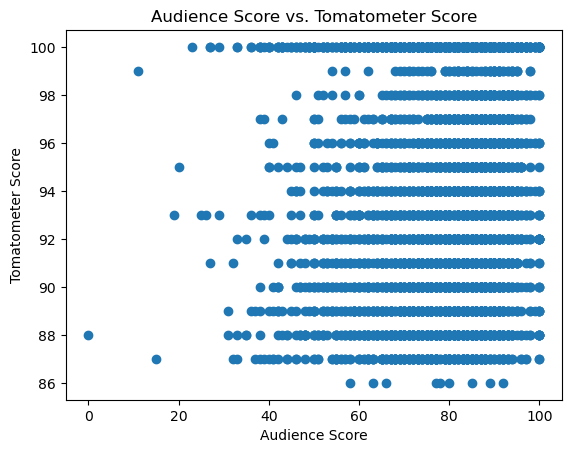

In [36]:
plt.scatter(df['audienceScore'], df['tomatoMeter'])
plt.xlabel('Audience Score')
plt.ylabel('Tomatometer Score')
plt.title('Audience Score vs. Tomatometer Score')
plt.show()

#### Line Chart

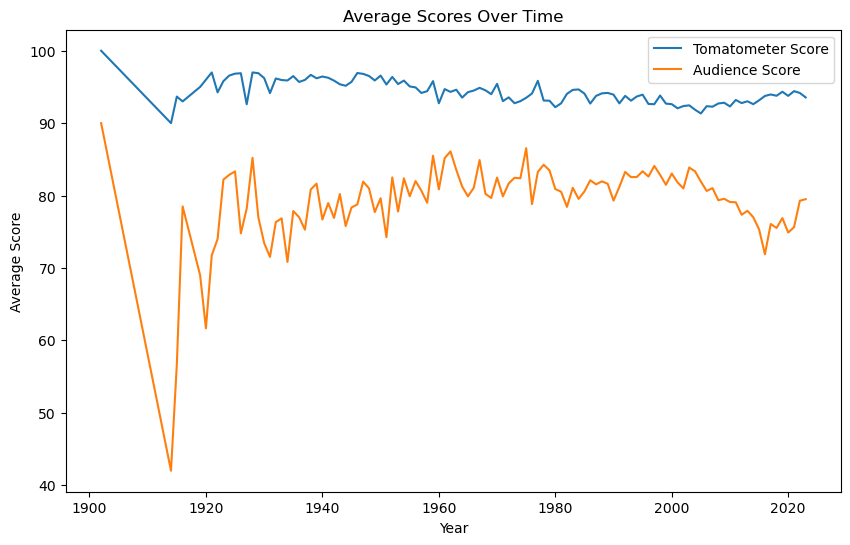

In [37]:
# Calculate average scores by year
avg_scores_by_year = df.groupby('year').agg({'tomatoMeter': 'mean', 'audienceScore': 'mean'}).reset_index()

plt.figure(figsize=(10, 6))
plt.plot(avg_scores_by_year['year'], avg_scores_by_year['tomatoMeter'], label='Tomatometer Score')
plt.plot(avg_scores_by_year['year'], avg_scores_by_year['audienceScore'], label='Audience Score')
plt.xlabel('Year')
plt.ylabel('Average Score')
plt.title('Average Scores Over Time')
plt.legend()
plt.show()

#### Bar Chart

In [ ]:
# Filter for languages
languages = ['Arabic', 'Yiddish', 'English', 'Chinese', 'French', 'Spanish']
filtered_df = df[df['originalLanguage'].isin(languages)]

In [40]:
# average scores by language
avg_scores_by_lang = filtered_df.groupby('originalLanguage').agg({'tomatoMeter': 'mean', 'audienceScore': 'mean'}).reset_index()
avg_scores_by_lang

,originalLanguage,tomatoMeter,audienceScore
0,Arabic,93.893617,81.021277
1,Chinese,93.917526,79.402062
2,English,93.734092,78.606246
3,French,94.000000,92.000000
4,Spanish,93.415842,75.722772
5,Yiddish,97.500000,64.500000


In [41]:
# Melt the df for easier plotting
avg_scores_melted = pd.melt(avg_scores_by_lang, id_vars=['originalLanguage'], value_vars=['tomatoMeter', 'audienceScore'], var_name='Score Type', value_name='Average Score')
avg_scores_melted

,originalLanguage,Score Type,Average Score
0,Arabic,tomatoMeter,93.893617
1,Chinese,tomatoMeter,93.917526
2,English,tomatoMeter,93.734092
3,French,tomatoMeter,94.000000
4,Spanish,tomatoMeter,93.415842
5,Yiddish,tomatoMeter,97.500000
6,Arabic,audienceScore,81.021277
7,Chinese,audienceScore,79.402062
8,English,audienceScore,78.606246
9,French,audienceScore,92.000000


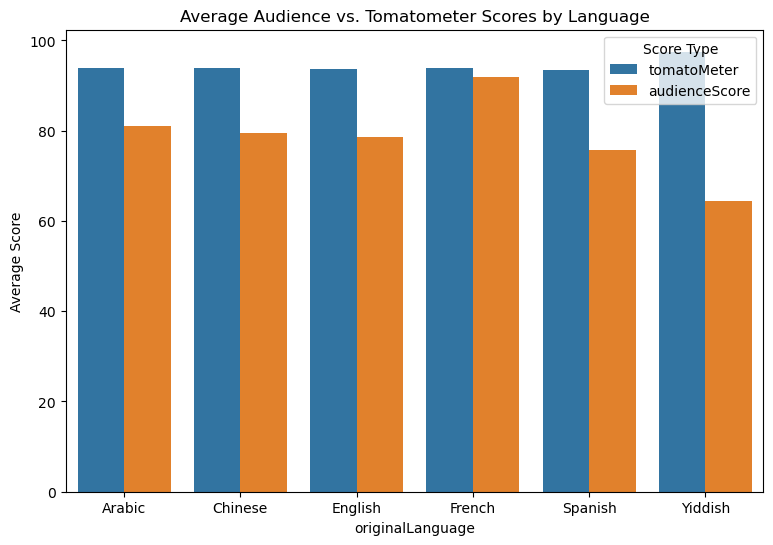

In [42]:
# Plot bar chart
plt.figure(figsize=(9, 6))
sns.barplot(x='originalLanguage', y='Average Score', hue='Score Type', data=avg_scores_melted)
plt.title('Average Audience vs. Tomatometer Scores by Language')
plt.show()

### Extended Challenges

1. Convert: Convert boxOffice to a number. Take into account that the string format includes a suffix such as "K", "M", "B", etc.

In [47]:
print(df["boxOffice"])

0          None
1       $234.2K
2          None
3          None
4          None
         ...   
4995       None
4996       None
4997      $1.1M
4998     $30.7K
4999       None
Name: boxOffice, Length: 5000, dtype: object


In [51]:
print(df['boxOffice'].unique())

[None '$234.2K' '$130.1K' ... '$853.7K' '$261.5K' '$30.7K']


In [55]:
# convert box office str to numeric value
def convert_box_office(value):
    if pd.isna(value) or not isinstance(value, str): 
        return None
        
    value = value.replace('$', '')  
    
    try:
        if 'K' in value:
            return float(value.replace('K', '')) * 1_000
        elif 'M' in value:
            return float(value.replace('M', '')) * 1_000_000
        elif 'B' in value:
            return float(value.replace('B', '')) * 1_000_000_000
        else:
            return float(value)
    except:
        print(f"Unexpected value encountered: {value}")
        return None

# Apply conversion function to boxOffice col
df['boxOfficeNum'] = df['boxOffice'].apply(convert_box_office)

print(df[['boxOffice', 'boxOfficeNum']].head(10))

Unexpected value encountered: Waldemar Young"
  boxOffice  boxOfficeNum
0      None           NaN
1   $234.2K      234200.0
2      None           NaN
3      None           NaN
4      None           NaN
5      None           NaN
6      None           NaN
7      None           NaN
8      None           NaN
9   $130.1K      130100.0


In [58]:
filtered_df = df[df['boxOfficeNum'].notna()]
print(filtered_df[['boxOffice', 'boxOfficeNum']].head(25))

    boxOffice  boxOfficeNum
1     $234.2K      234200.0
9     $130.1K      130100.0
11     $40.0K       40000.0
14     $15.7M    15700000.0
15     $44.3K       44300.0
16     $25.8K       25800.0
26      $4.0K        4000.0
28       $390         390.0
30     $12.0M    12000000.0
36     $45.4K       45400.0
37    $121.5K      121500.0
42    $101.5K      101500.0
43     $71.7K       71700.0
47     $91.3K       91300.0
55     $67.6K       67600.0
59     $11.5K       11500.0
70      $6.2K        6200.0
71      $4.3K        4300.0
72     $27.9K       27900.0
81     $39.4K       39400.0
84    $109.7K      109700.0
93     $42.0K       42000.0
97     $51.0K       51000.0
100     $4.7M     4700000.0
102    $12.2K       12200.0


> Depending on further analysis, drop NaN and unexpected values